<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250px"/>

# Logistic Regression
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2022 University of Illinois Board of Trustees. All Rights Reserved.

# Setup

## imports and graphics configurations

In [ ]:
import os
import numpy
import pandas
idx=pandas.IndexSlice
import time
import random
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter



def saver(fname,dpi=600):
    plt.savefig(fname+".png",bbox_inches="tight",dpi=dpi)

def legend(pos="bottom",ncol=3,extra=False):
    if pos=="bottom":
        extra = 0.15 if extra else 0
        plt.legend(bbox_to_anchor=(0.5,-0.2-extra), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
import sklearn.linear_model

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
print([os.remove(f) for f in pngfiles])

existing png files: ['bias.png', 'contour.png', 'contour_scored.png', 'datapolytope.png', 'dataset.png', 'decreasing_cost.png', 'dlogistic.png', 'dphientropy.png', 'entropy.png', 'fittedlogistic.png', 'gradient_descent.png', 'grad_flow.png', 'hist.png', 'logistic.png', 'logistic_scaled.png', 'logistic_transition.png', 'metric.png', 'multiclass.png', 'multiclass_scatterplot.png', 'normalization.png', 'odds.png', 'perfectimperfect.png', 'perfect_cost.png', 'perfect_cost_negative.png', 'perfect_cost_positive.png', 'perfect_data.png', 'perfect_data_plus_logistic.png', 'phientropy.png', 'polytope.png', 'quantized.png', 'scaling.png', 'scaling_params.png', 'truncatedhist.png']
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [ ]:
def getfile(location_pair,indict={}): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pandas.read_csv(loc,*indict)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pandas.read_csv(loc,*indict)
    return out

## configuration variables

In [ ]:
url="https://www.redfin.com"
fname=("redfin_data.csv","https://drive.google.com/file/d/1BFgKwV58YkPX_PRWMuKRHQoT6T0de_Qf/view?usp=sharing")
class1_color="red"
class0_color="blue"
SEED=0
markersize=5
thinlinewidth=2
textboxsize=(5,0.5)
x_max=6
default_bincount=12

# main

In [ ]:
(feature,featurescale,featurename)=("SQUARE FEET",1000,"SQUARE FEET/1000")
#(feature,featurescale,featurename)=("PRICE",1.0E6,"PRICE/$1M")
(label,class1_value,labelname)=("PROPERTY TYPE","Single Family Residential","SFR")

In [ ]:
text="\\begin{{center}}data provided by \\url{{{0:s}}}, a national real estate brokerage\\end{{center}}"
with open("dataurl.tex","w") as f:
    f.write(text.format(url))
f.close()

## load data

In [ ]:
data_raw=getfile(fname)
data_raw.head()

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,NaN,Single Family Residential,333 Dodge Ave,Evanston,IL,60202,339900,3.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/333-Dodge-A...,MRED,11818689,N,Y,42.024226,-87.699124
1,MLS Listing,NaN,Condo/Co-op,2254 Sherman Ave #2,Evanston,IL,60201,199000,2.0,1.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/2254-Sherma...,MRED,11831019,N,Y,42.059131,-87.682292
2,MLS Listing,NaN,Single Family Residential,2701 Noyes St,Evanston,IL,60201,1075000,5.0,3.5,...,Active,August-5-2023 11:00 AM,August-5-2023 01:00 PM,https://www.redfin.com/IL/Evanston/2701-Noyes-...,MRED,11850222,N,Y,42.058239,-87.710956
3,MLS Listing,NaN,Townhouse,1507 Wilder St,Evanston,IL,60202,825000,4.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1507-Wilder...,MRED,11849960,N,Y,42.040571,-87.693225
4,MLS Listing,NaN,Single Family Residential,9409 Crawford Ave,Evanston,IL,60203,525000,3.0,1.5,...,Active,August-6-2023 02:00 PM,August-6-2023 04:00 PM,https://www.redfin.com/IL/Evanston/9409-Crawfo...,MRED,11849554,N,Y,42.052003,-87.727151


In [ ]:
data=data_raw.copy()
data.index+=1
data.index.name="record number"

In [ ]:
data.head(1).transpose().to_latex(buf="sample_raw_data.tex",bold_rows=True)

C:\Users\richa\AppData\Local\Temp\ipykernel_22928\3737538519.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data.head(1).transpose().to_latex(buf="sample_raw_data.tex",bold_rows=True)


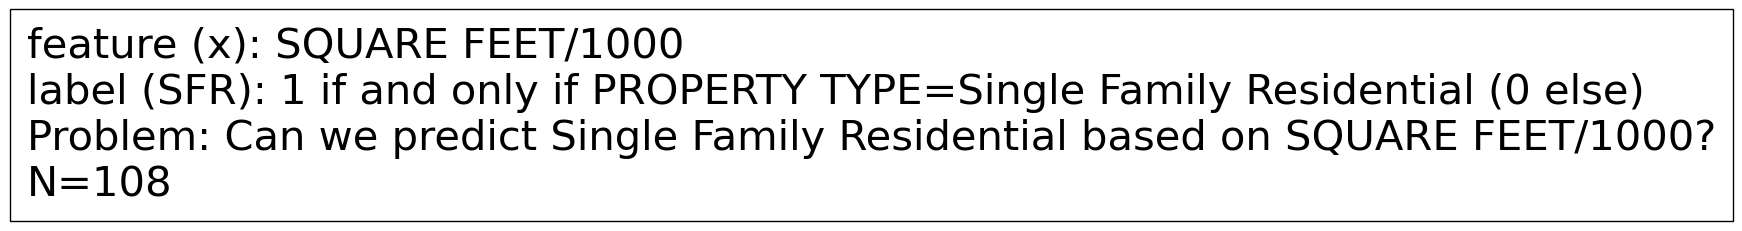

In [ ]:
text=[]
text.append("feature (x): {0:s}".format(featurename))
text.append(r"label ({2:s}): 1 if and only if {0:s}={1:s} (0 else)".format(label,class1_value,labelname))
text.append("Problem: Can we predict {0:s} based on {1:s}?".format(class1_value,featurename))
text.append("N={0:d}".format(len(data)))
textbox(text,fname="dataset")

In [ ]:
XY=data[[feature,label]].dropna(axis='index')
XY.columns=[featurename,labelname]
XY[featurename]=XY[featurename]/featurescale
XY[labelname]=(XY[labelname]==class1_value).astype(int)
X=XY[featurename]
Y=XY[labelname]
X_1=X[Y==1]
X_0=X[Y==0]
XY.head()

,SQUARE FEET/1000,SFR
record number,,
1,1.520,1
2,0.900,0
3,3.135,1
4,3.219,0
5,1.600,1


In [ ]:
XY.head().to_latex(buf="featurelabel.tex",bold_rows=True)

C:\Users\richa\AppData\Local\Temp\ipykernel_22928\1711968995.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  XY.head().to_latex(buf="featurelabel.tex",bold_rows=True)


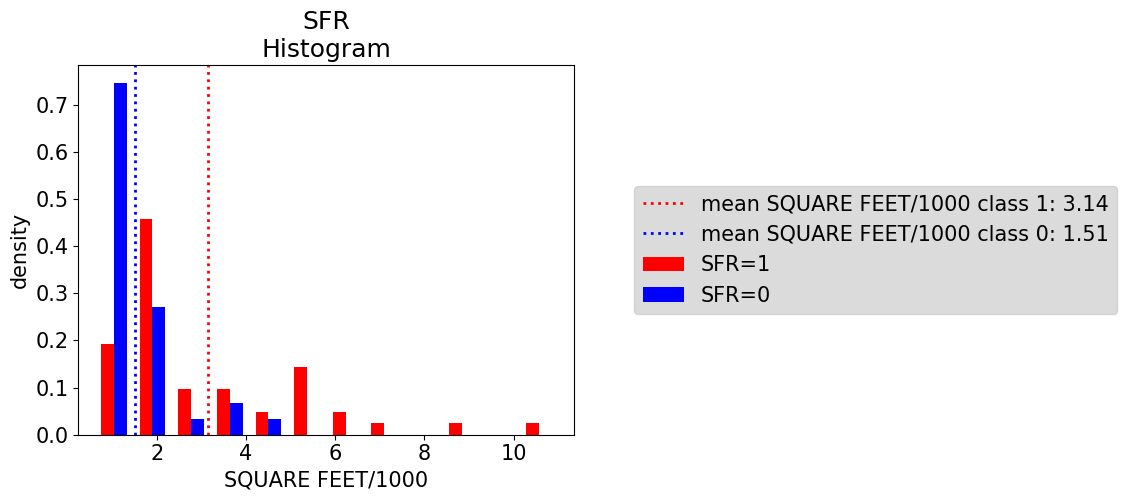

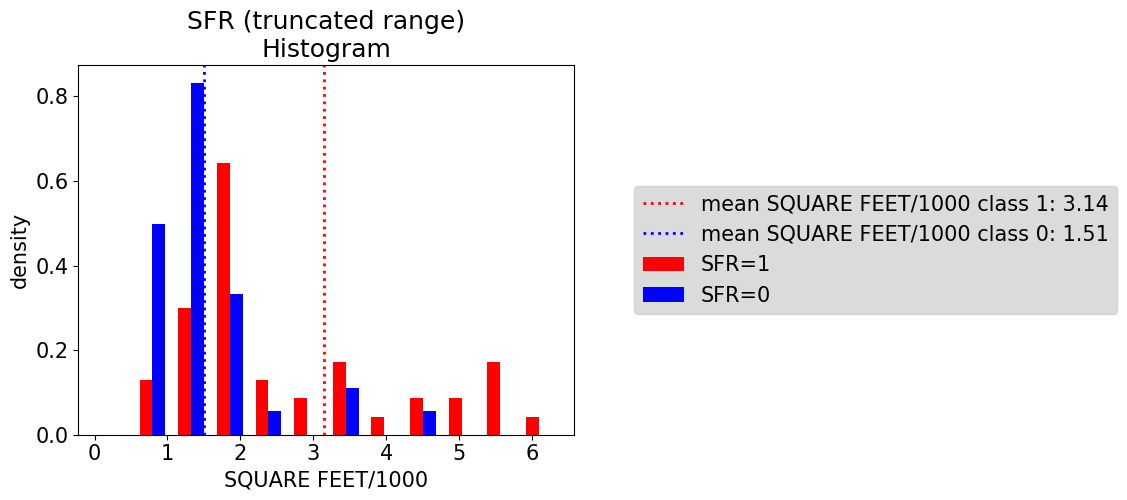

In [ ]:
_,combined_bins=numpy.histogram(X,bins=default_bincount)
bin_centers=(combined_bins[:-1]+combined_bins[1:])/2
binwidth=numpy.mean(combined_bins[1:]-combined_bins[:-1])

data_1_hist,_=numpy.histogram(X_1,bins=combined_bins,density=True)
data_0_hist,_=numpy.histogram(X_0,bins=combined_bins,density=True)
plt.figure()
plt.bar(bin_centers-binwidth/6,data_1_hist,width=binwidth/3,color=class1_color,label="SFR=1")
plt.bar(bin_centers+binwidth/6,data_0_hist,width=binwidth/3,color=class0_color,label="SFR=0")
plt.axvline(X_1.mean(),label="mean {0:s} class 1: {1:0.2f}".format(featurename,X_1.mean()),
    color=class1_color,ls=":",lw=thinlinewidth)
plt.axvline(X_0.mean(),label="mean {0:s} class 0: {1:0.2f}".format(featurename,X_0.mean()),
    color=class0_color,ls=":",lw=thinlinewidth)
plt.xlabel(featurename)
plt.ylabel("density")
title=[]
title.append(labelname)
title.append("Histogram")
plt.title("\n".join(title))
legend("side")
saver("hist")
plt.show()
plt.close()

####################

(Xmean,Xstd)=(X.mean(),X.std())
Xrange=(max(0,Xmean-2*Xstd),Xmean+2*Xstd)
_,combined_bins=numpy.histogram(X,bins=default_bincount,range=Xrange)
bin_centers=(combined_bins[:-1]+combined_bins[1:])/2
binwidth=numpy.mean(combined_bins[1:]-combined_bins[:-1])

data_1_hist,_=numpy.histogram(X_1,bins=combined_bins,density=True)
data_0_hist,_=numpy.histogram(X_0,bins=combined_bins,density=True)
plt.figure()
plt.bar(bin_centers-binwidth/6,data_1_hist,width=binwidth/3,color=class1_color,label="SFR=1")
plt.bar(bin_centers+binwidth/6,data_0_hist,width=binwidth/3,color=class0_color,label="SFR=0")
plt.axvline(X_1.mean(),label="mean {0:s} class 1: {1:0.2f}".format(featurename,X_1.mean()),
    color=class1_color,ls=":",lw=thinlinewidth)
plt.axvline(X_0.mean(),label="mean {0:s} class 0: {1:0.2f}".format(featurename,X_0.mean()),
    color=class0_color,ls=":",lw=thinlinewidth)
plt.xlabel(featurename)
plt.ylabel("density")
title=[]
title.append(labelname+ " (truncated range)")
title.append("Histogram")
plt.title("\n".join(title))
legend("side")
saver("truncatedhist")
plt.show()
plt.close()

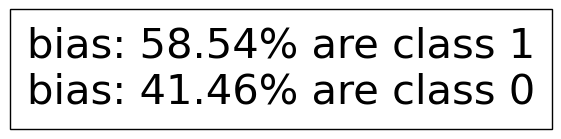

In [ ]:
text=[]
text.append("bias: {0:.2%} are class 1".format(numpy.mean(Y==1)))
text.append("bias: {0:.2%} are class 0".format(numpy.mean(Y==0)))
#text_str.append(r"$\sup|F_e-F_t|$={0:.2f}".format(maxval))
textbox(text,fname="bias")

In [ ]:
class LogisticRegression:
    def __init__(self,x,y):
        self.xvals=numpy.array(x)
        self.yvals=numpy.array(y)
        self.oneflags=numpy.array(self.yvals==1,dtype=float)
        self.zeroflags=numpy.array(self.yvals==0,dtype=float)

        self.XXvals=numpy.vstack([self.xvals,[1]*len(self.xvals)])
        self.reset()

    def reset(self):
        self.ctr=0
        self.callbacktext=[]

    @staticmethod
    def logistic(x,include_gradient=False):
        out=1/(1+numpy.exp(-x))
        if include_gradient:
            dout=numpy.exp(-x)/(1+numpy.exp(-x))**2
            out=(out,dout)
        return out

    @staticmethod
    def linear_function(p):
        (m,b)=p
        def lf(x):
            return m*x+b
        return lf

    @staticmethod
    def quantize(x):
        return (x>0.5).astype('int')

    def Loss(self,p,include_gradient=False):
        mx_plus_b=self.linear_function(p)(self.xvals)
        loss_minus=1+numpy.exp(-mx_plus_b)
        loss_plus=1+numpy.exp(mx_plus_b)
        loss=self.oneflags*numpy.log(loss_minus)+self.zeroflags*numpy.log(loss_plus)
        out=numpy.mean(loss)
        if include_gradient:
            dloss=(-1)*self.oneflags/loss_plus+self.zeroflags/loss_minus
            dloss=dloss*self.XXvals
            dloss=numpy.mean(dloss,axis=1)
            out=(out,dloss)
        return out

    def metric(self,p):
        (m,b)=p
        err=self.yvals-self.quantize(self.linear_function(p)(self.xvals))
        return numpy.mean(numpy.abs(err))

    def callback(self,x,verbose=False):
        (m,b)=p
        outstr="ctr={0:}; (m,b)=({1:.3f},{2:.2E}); error={3:.2E}".format(self.ctr,m,b,self.Loss(p))
        self.callbacktext.append(outstr)
        if verbose:
            print(outstr)
        self.ctr+=1

LR=LogisticRegression(X,Y)

In [ ]:
xvals_max=numpy.linspace(-x_max,x_max,num=1000)

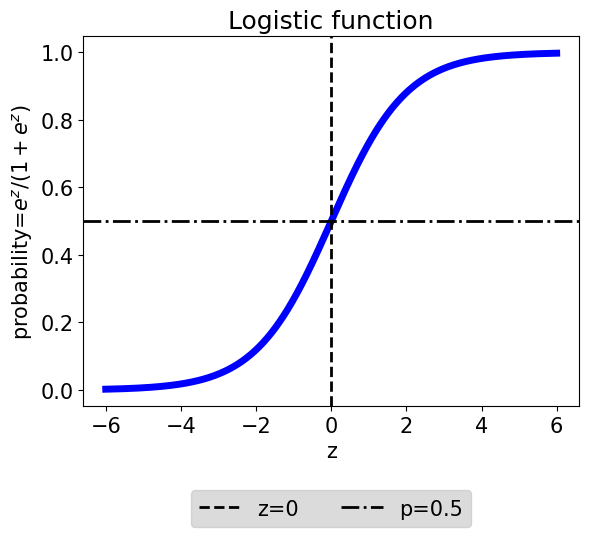

In [ ]:
plt.figure()
plt.plot(xvals_max,LogisticRegression.logistic(xvals_max),color="blue")
plt.axvline(0,lw=thinlinewidth,color="black",ls="dashed",label="z=0")
plt.axhline(0.5,lw=thinlinewidth,color="black",ls="dashdot",label="p=0.5")
title=[]
title.append("Logistic function")
plt.title("\n".join(title))
plt.xlabel("z")
plt.ylabel(r"probability=$e^z/(1+e^z)$")
legend("bottom")
saver("logistic")
plt.show()
plt.close()

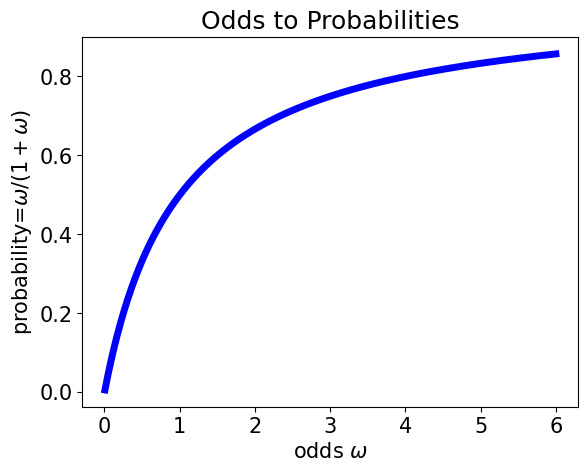

In [ ]:
def odds(omega):
    return omega/(1+omega)

plt.figure()
plt.plot(xvals_max[xvals_max>=0],odds(xvals_max[xvals_max>=0]),color="blue")
title=[]
title.append("Odds to Probabilities")
plt.title("\n".join(title))
plt.xlabel(r"odds $\omega$")
plt.ylabel(r"probability=$\omega/(1+\omega)$")
saver("odds")
plt.show()
plt.close()

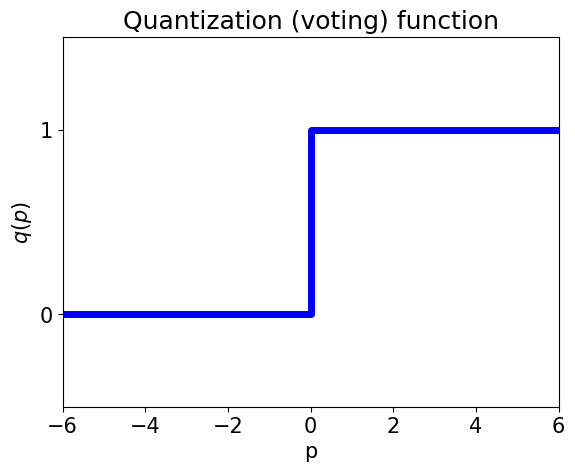

In [ ]:
plt.figure()
plt.step([-x_max,0,x_max],[0,1,1],where="post",color="blue")
plt.xlim(-x_max,x_max)
plt.ylim(-0.5,1.5)
title=[]
title.append("Quantization (voting) function")
plt.title("\n".join(title))
plt.xlabel("p")
plt.ylabel(r"$q(p)$")
plt.yticks([0,1])
saver("quantized")
plt.show()
plt.close()

In [ ]:
admitted_data=X[Y==1]
mean_feature_admitted=admitted_data.mean()
std_feature_admitted=admitted_data.std()
print(mean_feature_admitted,std_feature_admitted)

denied_data=X[Y==0]
mean_feature_denied=denied_data.mean()
std_feature_denied=denied_data.std()
print(mean_feature_denied,std_feature_denied)

3.1434374999999997 2.221771374053557
1.5059411764705881 0.8194523648468649


In [ ]:
lr=sklearn.linear_model.LogisticRegression(solver="lbfgs",random_state=0,penalty=None).fit(X.values.reshape(-1,1),Y.values)
(m_opt,b_opt)=(lr.coef_.item(),lr.intercept_.item())
center_opt=-b_opt/m_opt
print("m="+str(m_opt)+"; b="+str(b_opt)+"; center="+str(center_opt))

m=0.9535787380107962; b=-1.5811543323170292; center=1.6581266646269621


In [ ]:
(Xmean,Xstd)=(X.mean(),X.std())
Xrange=(max(0,Xmean-2*Xstd),Xmean+2*Xstd)
total_counts,total_bins=numpy.histogram(X,bins=default_bincount,range=Xrange)
class1_counts,_=numpy.histogram(X_1,bins=total_bins)
class1_frequency=numpy.nan_to_num(class1_counts/total_counts)
class0_counts,_=numpy.histogram(X_0,bins=total_bins)
class0_frequency=numpy.nan_to_num(class0_counts/total_counts)
bin_centers=(total_bins[1:]+total_bins[:-1])/2
widths=0.9*numpy.mean(total_bins[1:]-total_bins[:-1])

C:\Users\richa\AppData\Local\Temp\ipykernel_22928\3294448317.py:5: RuntimeWarning: invalid value encountered in divide
  class1_frequency=numpy.nan_to_num(class1_counts/total_counts)
C:\Users\richa\AppData\Local\Temp\ipykernel_22928\3294448317.py:7: RuntimeWarning: invalid value encountered in divide
  class0_frequency=numpy.nan_to_num(class0_counts/total_counts)


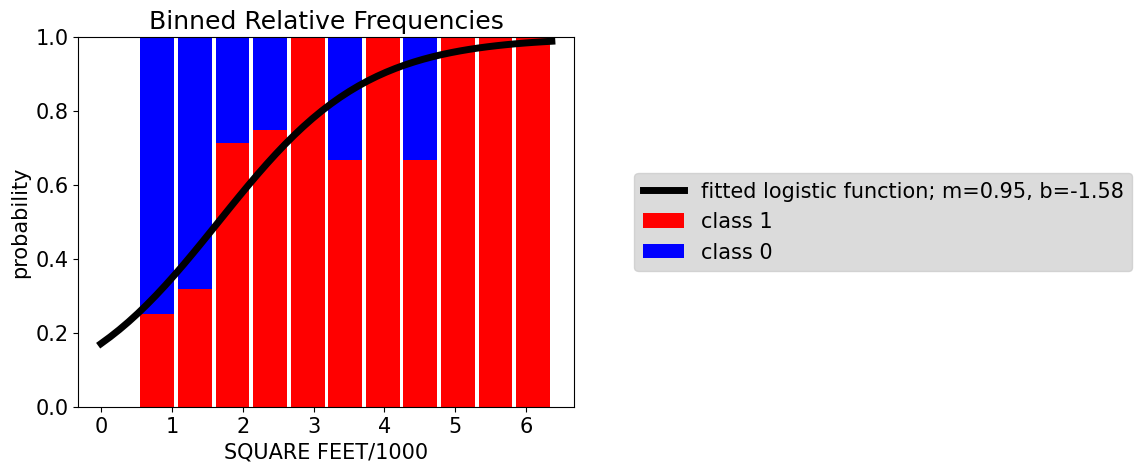

In [ ]:
xrange=numpy.linspace(total_bins[0],total_bins[-1])
qvalues=LR.logistic(LR.linear_function((m_opt,b_opt))(xrange))

plt.figure()
plt.bar(bin_centers,class1_frequency,bottom=0,width=widths,color=class1_color,label="class 1")
plt.bar(bin_centers,class0_frequency,bottom=class1_frequency,width=widths,color=class0_color,label="class 0")
plt.plot(xrange,qvalues,color="black",label="fitted logistic function; m={:.2f}, b={:.2f}".format(m_opt,b_opt))
plt.xlabel(featurename)
plt.ylabel("probability")
title=[]
title.append("Binned Relative Frequencies")
plt.title("\n".join(title))
legend("side")
saver("fittedlogistic")
plt.show()
plt.close()

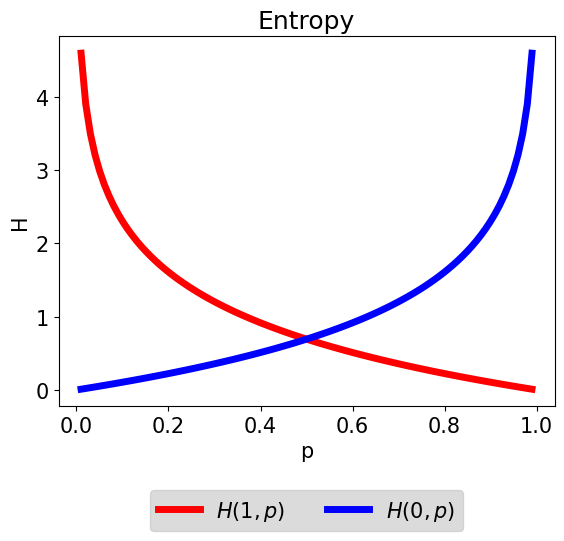

In [ ]:
pvals=numpy.linspace(0,1,num=100)
pvals=pvals[(pvals>0) & (pvals<1)]

plt.figure()
plt.plot(pvals,-numpy.log(pvals),label=r"$H(1,p)$",color=class1_color)
plt.plot(pvals,-numpy.log(1-pvals),label=r"$H(0,p)$",color=class0_color)
title=[]
title.append("Entropy")
plt.title("\n".join(title))
plt.xlabel("p")
plt.ylabel("H")
legend("bottom")
saver("entropy")
plt.show()
plt.close()

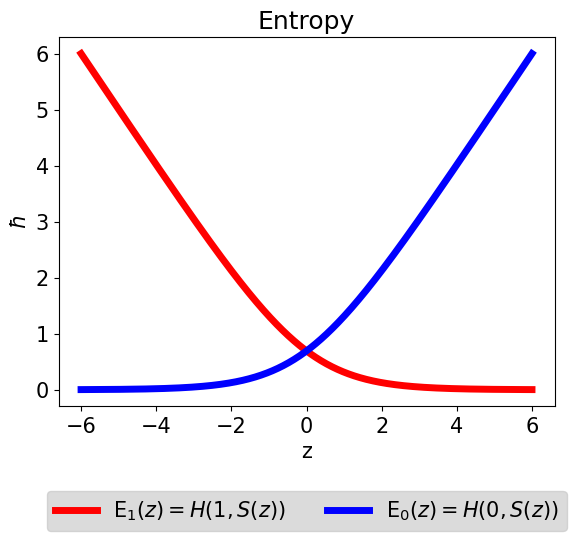

In [ ]:
plt.figure()
plt.plot(xvals_max,numpy.log(1+numpy.exp(-xvals_max)),label=r"$\mathsf{E}_1(z)=H(1,S(z))$",color=class1_color)
plt.plot(xvals_max,numpy.log(1+numpy.exp(xvals_max)),label=r"$\mathsf{E}_0(z)=H(0,S(z))$",color=class0_color)
title=[]
title.append("Entropy")
plt.title("\n".join(title))
plt.xlabel("z")
plt.ylabel(r"$\hbar$")
legend("bottom")
saver("phientropy")
plt.show()
plt.close()

In [ ]:
(dm_opt,db_opt)=(2*numpy.abs(m_opt),2*numpy.abs(b_opt))
Mvals = numpy.linspace(m_opt-dm_opt,m_opt+dm_opt)
Bvals = numpy.linspace(b_opt-db_opt,b_opt+db_opt)
Mgrid, Bgrid = numpy.meshgrid(Mvals, Bvals)
Err=numpy.array([[LR.Loss([m,b]) for m in Mvals] for b in Bvals])
Err=numpy.sqrt(Err-numpy.min(Err))
#levels=numpy.linspace(start=minE,stop=minE+numpy.ptp(Err)/10,num=10)
levels=numpy.linspace(start=numpy.min(Err),stop=numpy.max(Err),num=10)

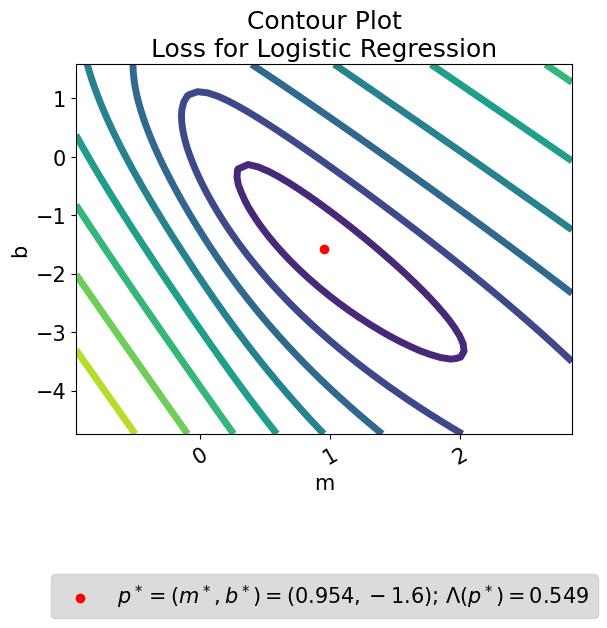

In [ ]:
plt.figure
plt.contour(Mvals,Bvals,Err,levels=levels)
title=[]
title.append("Contour Plot")
title.append("Loss for Logistic Regression")
plt.scatter(m_opt,b_opt,color="red",label=r"$p^*=(m^*,b^*)=({0:.3f},{1:.1f})$; $\Lambda(p^*)={2:.3f}$".format(m_opt,b_opt,LR.Loss((m_opt,b_opt))))
plt.title("\n".join(title))
plt.xlim(m_opt-dm_opt,m_opt+dm_opt)
plt.ylim(b_opt-db_opt,b_opt+db_opt)
plt.xticks(rotation=30)
plt.xlabel("m")
plt.ylabel("b")
legend("bottom",extra=True)
saver("contour")
plt.show()
plt.close()

In [ ]:
def inverse_logistic(p):
    return -numpy.log(1/p-1)

p=0.05
preimage=numpy.abs(inverse_logistic(p))

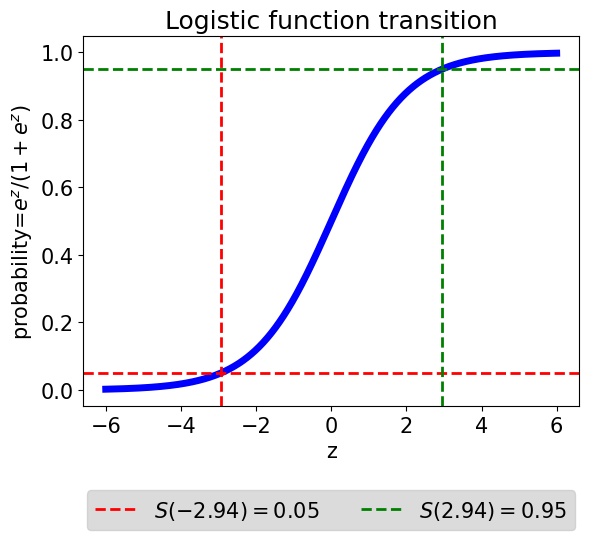

In [ ]:
plt.figure()
plt.plot(xvals_max,LogisticRegression.logistic(xvals_max),color="blue")
for (pp,pp_inv,color) in zip([p,1-p],[-preimage,preimage],["red","green"]):
    plt.axhline(pp,lw=thinlinewidth,color=color,ls="dashed")
    plt.axvline(pp_inv,lw=thinlinewidth,color=color,ls="dashed",label=r"$S({0:.2f})={1:.2f}$".format(pp_inv,pp))
title=[]
title.append("Logistic function transition")
plt.title("\n".join(title))
plt.xlabel("z")
plt.ylabel(r"probability=$e^z/(1+e^z)$")
legend("bottom")
saver("logistic_transition")
plt.show()
plt.close()

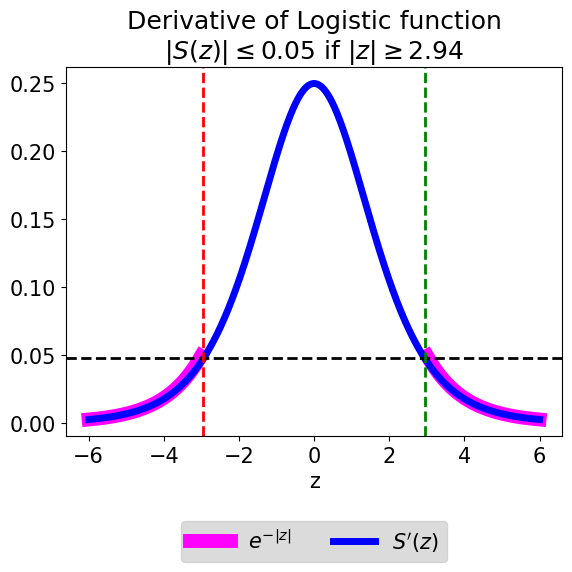

In [ ]:
_,dlogistic=LogisticRegression.logistic(xvals_max,include_gradient=True)
_,dlogistic_max=LogisticRegression.logistic(inverse_logistic(p),include_gradient=True)
plt.figure()
plt.plot(xvals_max[xvals_max>=3],numpy.exp(-numpy.abs(xvals_max[xvals_max>=3])),linewidth=10,color="magenta",label=r"$e^{-|z|}$")
plt.plot(xvals_max[xvals_max<=-3],numpy.exp(-numpy.abs(xvals_max[xvals_max<=-3])),linewidth=10,color="magenta")
plt.plot(xvals_max,dlogistic,color="blue",label=r"$S'(z)$")

plt.axhline(dlogistic_max,lw=thinlinewidth,color="black",ls="dashed")
for (pp_inv,color) in zip([-preimage,preimage],["red","green"]):
    plt.axvline(pp_inv,lw=thinlinewidth,color=color,ls="dashed")

title=[]
title.append("Derivative of Logistic function")
title.append(r"$|S(z)|\leq {0:.2f}$ if $|z|\geq {1:.2f}$".format(dlogistic_max,preimage))
plt.title("\n".join(title))
plt.xlabel("z")
legend("bottom")
saver("dlogistic")
plt.show()
plt.close()

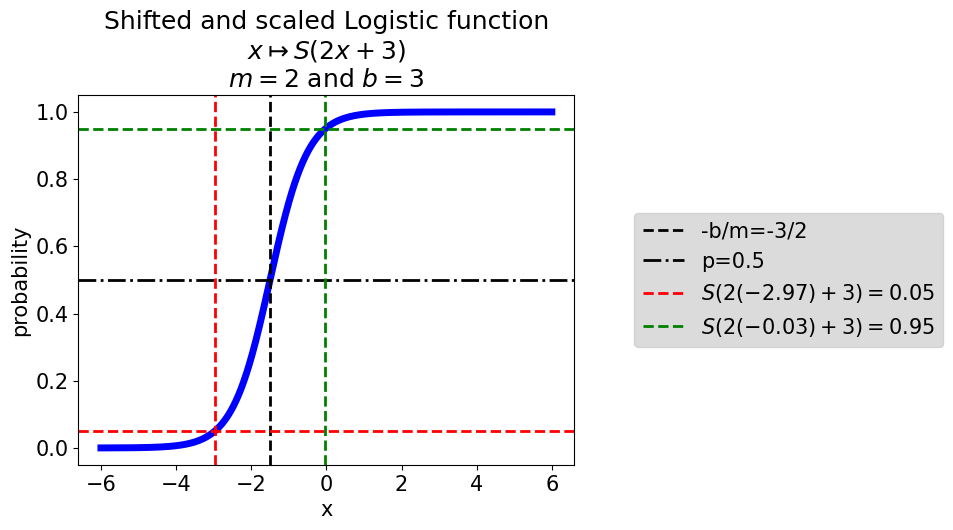

In [ ]:
(m,b)=(2,3)
center=-b/m
width=1/m


ell_x=m*xvals_max+b
plt.figure()
plt.plot(xvals_max,LogisticRegression.logistic(LogisticRegression.linear_function((m,b))(xvals_max)),color="blue")
plt.axvline(center,color="black",label=r"-b/m=-{1:d}/{0:d}".format(m,b),lw=thinlinewidth,ls="dashed")
plt.axhline(0.5,color="black",label="p=0.5",lw=thinlinewidth,ls="dashdot")

for (pp,pp_inv,color) in zip([p,1-p],[(-preimage-b)/m,(preimage-b)/m],["red","green"]):
    plt.axhline(pp,lw=thinlinewidth,color=color,ls="dashed")
    plt.axvline(pp_inv,lw=thinlinewidth,color=color,ls="dashed",label=r"$S\left(2({0:.2f})+3\right)={1:.2f}$".format(pp_inv,pp))


#plt.axvline(center-width,color="black",lw=thinlinewidth,ls="dashdot")
#plt.axvline(center+width,color="black",label=r"$-b/m\pm 1/m=-{1:d}/{0:d}\pm 1/{0:d}$".format(m,b),linewidth=thinlinewidth,ls="dashdot")
plt.xlabel("x")
plt.ylabel(r"probability")
title=[]
title.append("Shifted and scaled Logistic function")
title.append(r"$x\mapsto S({0:d}x+{1:d})$".format(m,b))
title.append(r"$m={0:d}$ and $b={1:d}$".format(m,b))
plt.title("\n".join(title))
legend("side")
saver("logistic_scaled")
plt.show()
plt.close()

In [ ]:
X_scored=scipy.stats.zscore(X)
(meanX,stdX)=(X.mean(),X.std())

def feature_to_scored(x):
    return (x-meanX)/stdX
def scored_to_feature(x):
    return meanX+x*stdX

LR_scored=LogisticRegression(X_scored,Y)
lr_scored=sklearn.linear_model.LogisticRegression(solver="lbfgs",random_state=0,penalty=None).fit(X_scored.values.reshape(-1,1),Y.values)
(m_scored_opt,b_scored_opt)=(lr_scored.coef_.item(),lr_scored.intercept_.item())
center_scored_opt=-b_scored_opt/m_scored_opt
print(m_scored_opt,center_scored_opt)

1.8466876632493558 -0.4163755218740678


In [ ]:
(dm_scored_opt,db_scored_opt)=(2*numpy.abs(m_scored_opt),2*numpy.abs(b_scored_opt))
Mvals_scored = numpy.linspace(m_scored_opt-dm_scored_opt,m_scored_opt+dm_scored_opt)
Bvals_scored = numpy.linspace(b_scored_opt-db_scored_opt,b_scored_opt+db_scored_opt)
Mgrid_scored, Bgrid_scored = numpy.meshgrid(Mvals_scored, Bvals_scored)
Err_scored=numpy.array([[LR_scored.Loss([m,b]) for m in Mvals_scored] for b in Bvals_scored])
Err_scored=numpy.sqrt(Err_scored-numpy.min(Err_scored))
#levels=numpy.linspace(start=minE,stop=minE+numpy.ptp(Err)/10,num=10)
levels_scored=numpy.linspace(start=numpy.min(Err_scored),stop=numpy.max(Err_scored),num=10)

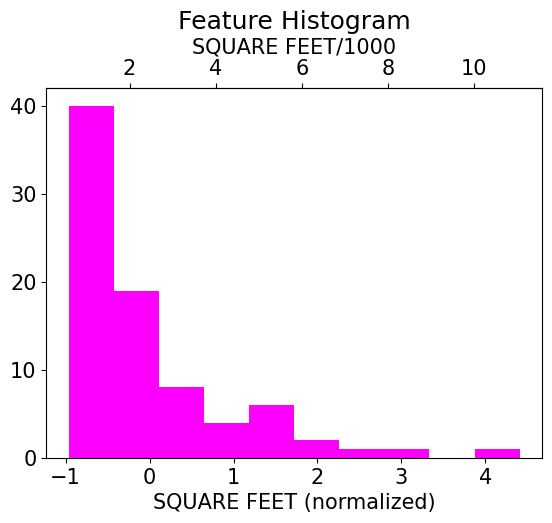

In [ ]:
plt.figure()
plt.hist(X_scored,color="magenta")
plt.xlabel(feature+" (normalized)")
secax = plt.gca().secondary_xaxis('top', functions=(scored_to_feature,feature_to_scored))
secax.set_xlabel(featurename)
title=[]
title.append("Feature Histogram")
plt.title("\n".join(title))
saver("normalization")
plt.show()
plt.close()

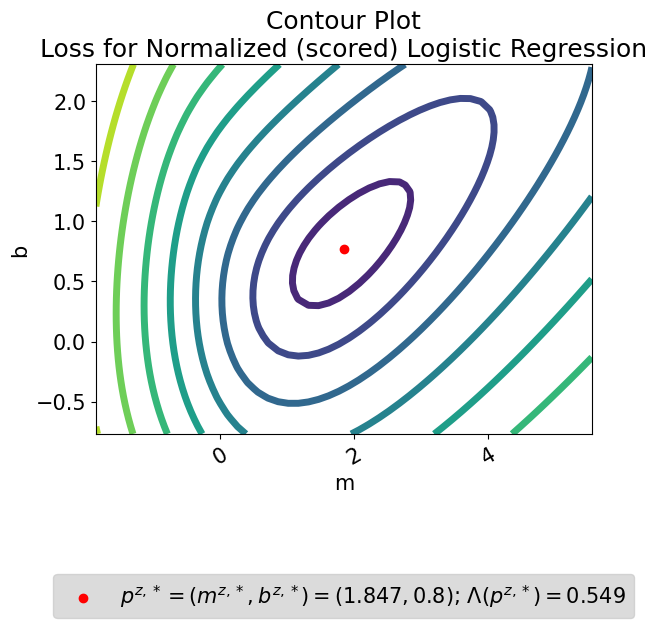

In [ ]:
plt.figure
plt.contour(Mvals_scored,Bvals_scored,Err_scored,levels=levels_scored)
title=[]
title.append("Contour Plot")
title.append("Loss for Normalized (scored) Logistic Regression")
plt.scatter(m_scored_opt,b_scored_opt,color="red",label=r"$p^{{z,*}}=(m^{{z,*}},b^{{z,*}})=({0:.3f},{1:.1f})$; $\Lambda(p^{{z,*}})={2:.3f}$".format(m_scored_opt,b_scored_opt,LR_scored.Loss((m_scored_opt,b_scored_opt))))
plt.title("\n".join(title))
plt.xlim(m_scored_opt-dm_scored_opt,m_scored_opt+dm_scored_opt)
plt.ylim(b_scored_opt-db_scored_opt,b_scored_opt+db_scored_opt)
plt.xticks(rotation=30)
plt.xlabel("m")
plt.ylabel("b")
legend("bottom",extra=True)
saver("contour_scored")
plt.show()
plt.close()

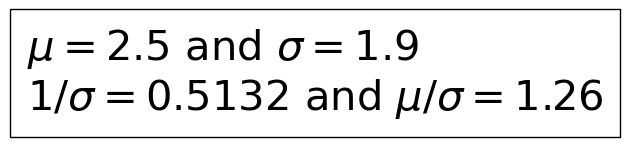

In [ ]:
text=[]
text.append(r"$\mu={0:.1f}$ and $\sigma={1:.1f}$".format(meanX,stdX))
text.append(r"$1/\sigma={0:.4f}$ and $\mu/\sigma={1:.2f}$".format(1/stdX,meanX/stdX))
textbox(text,fname="scaling")

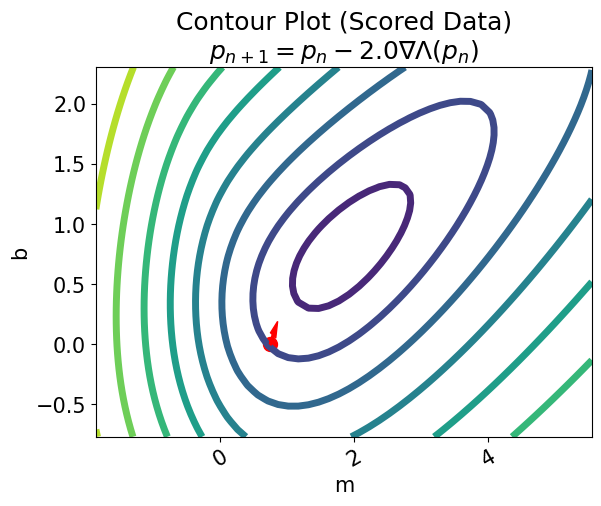

In [ ]:
(m_scored_init,b_scored_init)=(0.75,0)
_,(dm_scored_init,db_scored_init)=LR_scored.Loss([m_scored_init,b_scored_init],include_gradient=True)
delta=2

plt.figure
plt.contour(Mvals_scored,Bvals_scored,Err_scored,levels=levels_scored)
title=[]
title.append("Contour Plot (Scored Data)")
title.append(r"$p_{{n+1}}=p_n-{0:.1f}\nabla \Lambda(p_n)$".format(delta))
plt.scatter(m_scored_init,b_scored_init,s=100,color="red")
plt.arrow(m_scored_init,b_scored_init,-dm_scored_init*delta,-db_scored_init*delta,width=.03,color="r",linewidth=1,length_includes_head=True,zorder=10)
plt.title("\n".join(title))
plt.xlim(m_scored_opt-dm_scored_opt,m_scored_opt+dm_scored_opt)
plt.ylim(b_scored_opt-db_scored_opt,b_scored_opt+db_scored_opt)
plt.xticks(rotation=30)
plt.xlabel("m")
plt.ylabel("b")
#plt.legend(bbox_to_anchor=(0,-0.3), loc='upper left',ncol=3)
saver("gradient_descent")
plt.show()
plt.close()

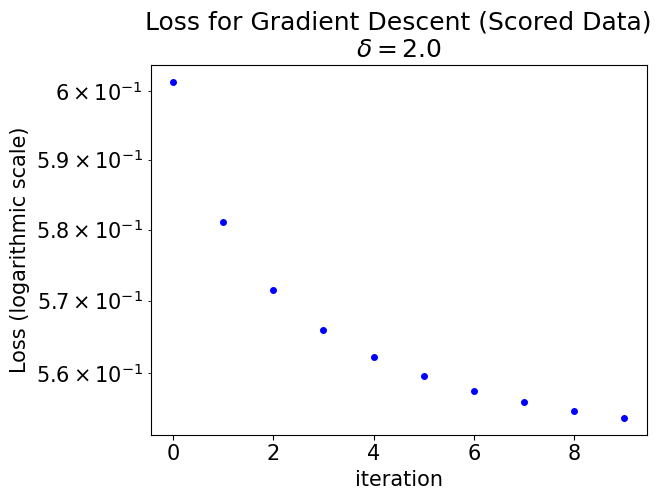

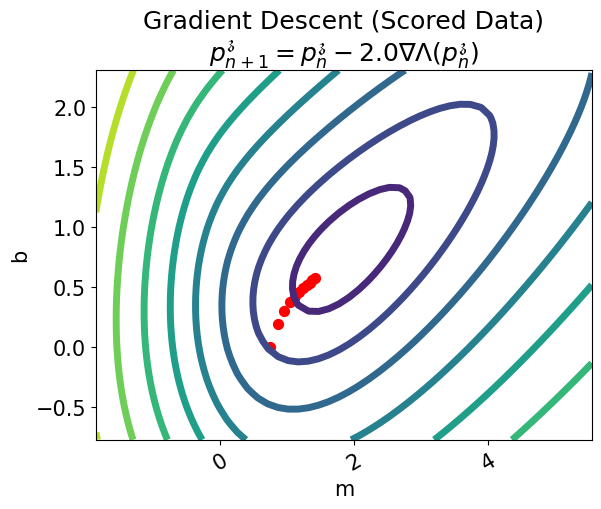

In [ ]:
(m_init,b_init)=(0.75,0)
state=numpy.array([m_init,b_init])
states=[(m_init,b_init)]
losses=[]
delta=2
N=10
for n in range(N):
    loss,gradient=LR_scored.Loss(state,include_gradient=True)
    losses.append(loss)
    state=state-delta*gradient
    states.append(state)

title=[]
title.append("Loss for Gradient Descent (Scored Data)")
title.append(r"$\delta={:.1f}$".format(delta))
plt.figure()
plt.semilogy(losses, 'bo',ms=4)
plt.ylabel("Loss (logarithmic scale)")
plt.xlabel("iteration")
plt.title("\n".join(title))
saver("decreasing_cost")
plt.show()
plt.close()

states_x=[x for (x,_) in states]
states_y=[y for (_,y) in states]
plt.figure
plt.contour(Mvals_scored,Bvals_scored,Err_scored,levels=levels_scored)
title=[]
title.append("Gradient Descent (Scored Data)")
title.append(r"$p^{{\mathfrak{{z}}}}_{{n+1}}=p^{{\mathfrak{{z}}}}_n-{0:.1f}\nabla \Lambda(p^{{\mathfrak{{z}}}}_n)$".format(delta))
plt.scatter(states_x,states_y,s=50,color="red")
plt.title("\n".join(title))
plt.xlim(m_scored_opt-dm_scored_opt,m_scored_opt+dm_scored_opt)
plt.ylim(b_scored_opt-db_scored_opt,b_scored_opt+db_scored_opt)
plt.xticks(rotation=30)
plt.xlabel("m")
plt.ylabel("b")
saver("grad_flow")
plt.show()
plt.close()

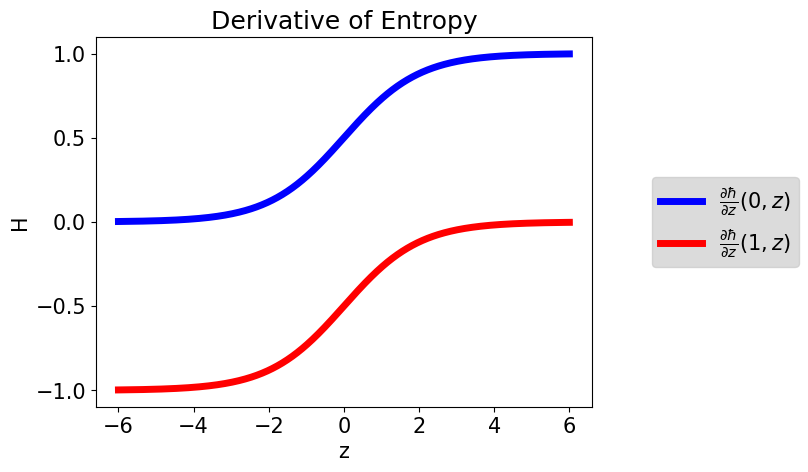

In [ ]:
plt.figure()
plt.plot(xvals_max,1/(1+numpy.exp(-xvals_max)),label=r"$\frac{\partial \hbar}{\partial z}(0,z)$",color=class0_color)
plt.plot(xvals_max,-1/(1+numpy.exp(xvals_max)),label=r"$\frac{\partial \hbar}{\partial z}(1,z)$",color=class1_color)
title=[]
title.append("Derivative of Entropy")
plt.title("\n".join(title))
plt.xlabel("z")
plt.ylabel("H")
legend("side")
saver("dphientropy")
plt.show()
plt.close()

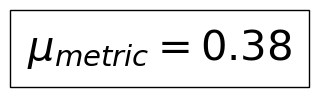

In [ ]:
text=[]
text.append(r"$\mu_{{metric}}={0:.2f}$".format(LR.metric((m_opt,b_opt))))
textbox(text,fname="metric")

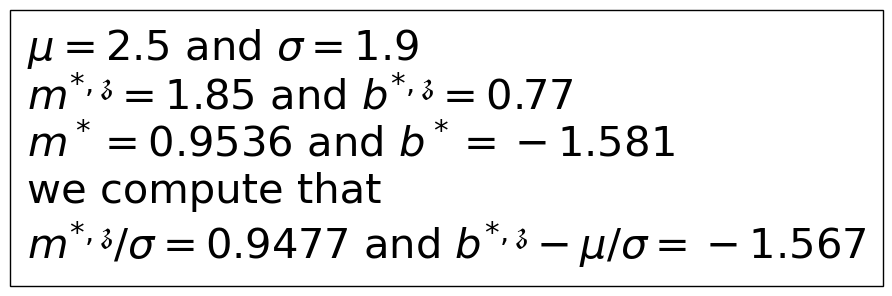

In [ ]:
text=[]
text.append(r"$\mu={0:.1f}$ and $\sigma={1:.1f}$".format(meanX,stdX))
text.append(r"$m^{{*,\mathfrak{{z}}}}={0:.2f}$ and $b^{{*,\mathfrak{{z}}}}={1:.2f}$".format(m_scored_opt,b_scored_opt))
text.append(r"$m^*={0:.4f}$ and $b^*={1:.3f}$".format(m_opt,b_opt))
text.append("we compute that")
text.append(r"$m^{{*,\mathfrak{{z}}}}/\sigma={0:.4f}$ and $b^{{*,\mathfrak{{z}}}}-\mu/\sigma={1:.3f}$".format(m_scored_opt/stdX,b_scored_opt-m_scored_opt*meanX/stdX))
textbox(text,fname="scaling_params")

### Regularization ###

In [ ]:
x_perfect=scipy.stats.norm.rvs(size=100,random_state=SEED)
y_perfect=(1+numpy.sign(x_perfect))/2

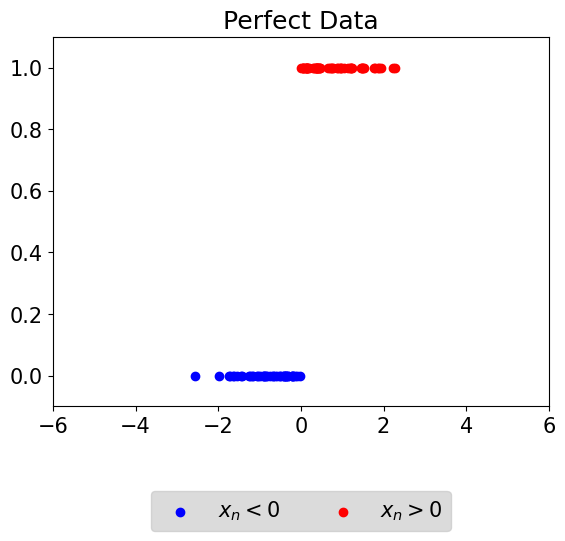

In [ ]:
plt.figure()
plt.scatter(x_perfect[x_perfect<0],y_perfect[x_perfect<0],color=class0_color,label=r"$x_n<0$")
plt.scatter(x_perfect[x_perfect>0],y_perfect[x_perfect>0],color=class1_color,label=r"$x_n>0$")
plt.ylim(-0.1,1.1)
plt.xlim(-x_max,x_max)
title=[]
title.append("Perfect Data")
plt.title("\n".join(title))
legend("bottom")
saver("perfect_data")
plt.show()
plt.close()

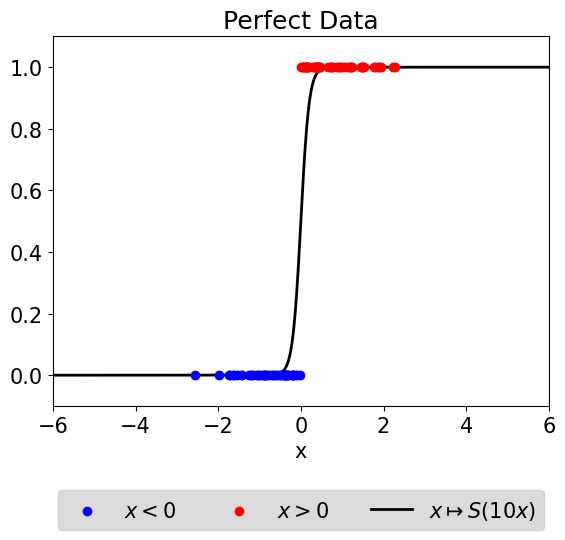

In [ ]:
plt.figure()
plt.scatter(x_perfect[x_perfect<0],y_perfect[x_perfect<0],color=class0_color,label=r"$x<0$")
plt.scatter(x_perfect[x_perfect>0],y_perfect[x_perfect>0],color=class1_color,label=r"$x>0$")
plt.plot(xvals_max,LogisticRegression.logistic(10*xvals_max),color="black",label=r"$x\mapsto S(10x)$",zorder=-1,linewidth=2)
plt.ylim(-0.1,1.1)
plt.xlim(-x_max,x_max)
plt.xlabel("x")
title=[]
title.append("Perfect Data")
plt.title("\n".join(title))
legend("bottom")
saver("perfect_data_plus_logistic")
plt.show()
plt.close()

In [ ]:
LR_perfect=LogisticRegression(x_perfect,y_perfect)

In [ ]:
m_max=50
x_abs_min=numpy.abs(x_perfect).min()
x_abs_mean=numpy.abs(x_perfect).mean()

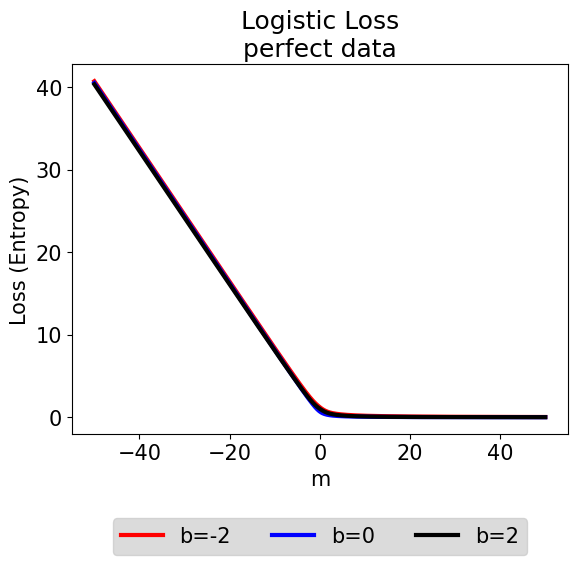

In [ ]:
mvals=numpy.linspace(-m_max,m_max,num=1000)
bvals=[-2,0,2]
colors=["red","blue","black"]
plt.figure()
for b,c in zip(bvals,colors):
    plt.plot(mvals,[LR_perfect.Loss([m,b]) for m in mvals],label="b={:.0f}".format(b),linewidth=3,color=c)

legend()
plt.xlabel("m")
plt.ylabel("Loss (Entropy)")
title=[]
title.append("Logistic Loss")
title.append("perfect data")
plt.title("\n".join(title))
legend("bottom")
saver("perfect_cost")
plt.show()
plt.close()

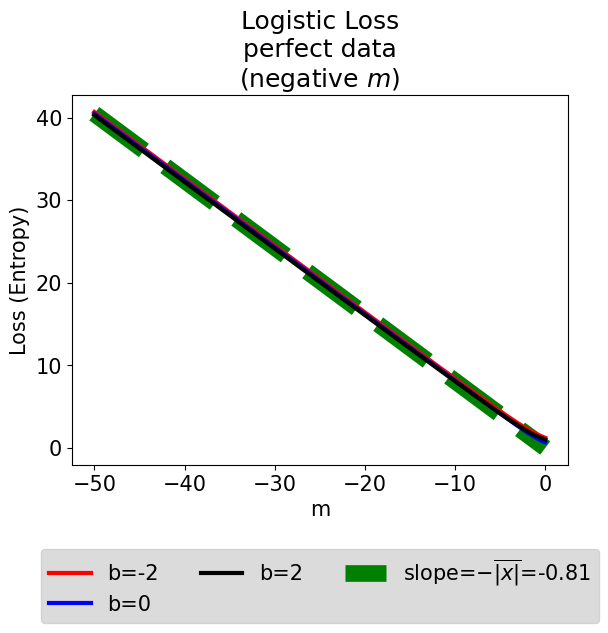

In [ ]:
mvals=numpy.linspace(-m_max,0,num=1000)
bvals=[-2,0,2]
colors=["red","blue","black"]
plt.figure()
for b,c in zip(bvals,colors):
    plt.plot(mvals,[LR_perfect.Loss([m,b]) for m in mvals],label="b={:.0f}".format(b),linewidth=3,color=c)
plt.plot(mvals,-x_abs_mean*mvals,color="green",linewidth=12,linestyle="dashed",
         label=r"slope=$-\overline{{|x|}}$={0:.2f}".format(-x_abs_mean),zorder=-5)
legend()
plt.xlabel("m")
plt.ylabel("Loss (Entropy)")
title=[]
title.append("Logistic Loss")
title.append("perfect data")
title.append("(negative $m$)")
plt.title("\n".join(title))
legend("bottom")
saver("perfect_cost_negative")
plt.show()
plt.close()

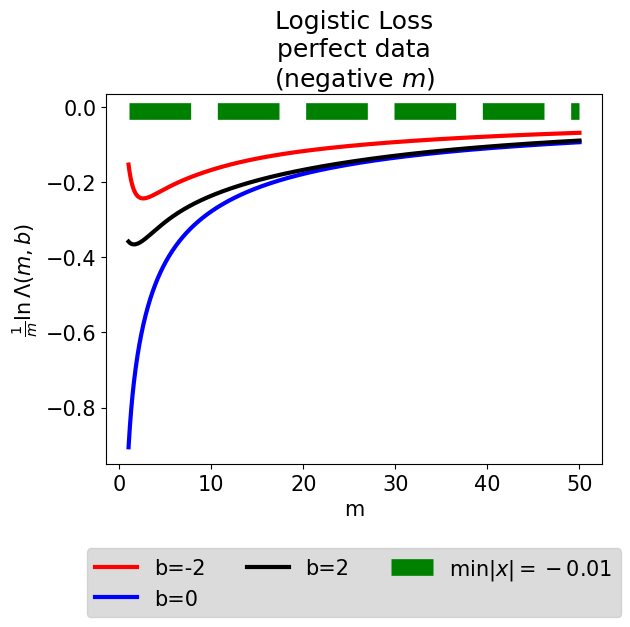

In [ ]:
mvals=numpy.linspace(1,m_max,num=1000)
mvals=mvals[mvals>0]
bvals=[-2,0,2]
colors=["red","blue","black"]
plt.figure()
for b,c in zip(bvals,colors):
    plt.plot(mvals,[numpy.log(LR_perfect.Loss([m,b]))/m for m in mvals],label="b={:.0f}".format(b),linewidth=3,color=c)
plt.plot(mvals,[-x_abs_min]*len(mvals),color="green",linewidth=12,linestyle="dashed",
         label=r"$\min|x|={0:.2f}$".format(-x_abs_min),zorder=-5)
legend()
plt.xlabel("m")
plt.ylabel(r"$\frac{1}{m}\ln \Lambda(m,b)$")
title=[]
title.append("Logistic Loss")
title.append("perfect data")
title.append("(negative $m$)")
plt.title("\n".join(title))
legend("bottom")
saver("perfect_cost_positive")
plt.show()
plt.close()

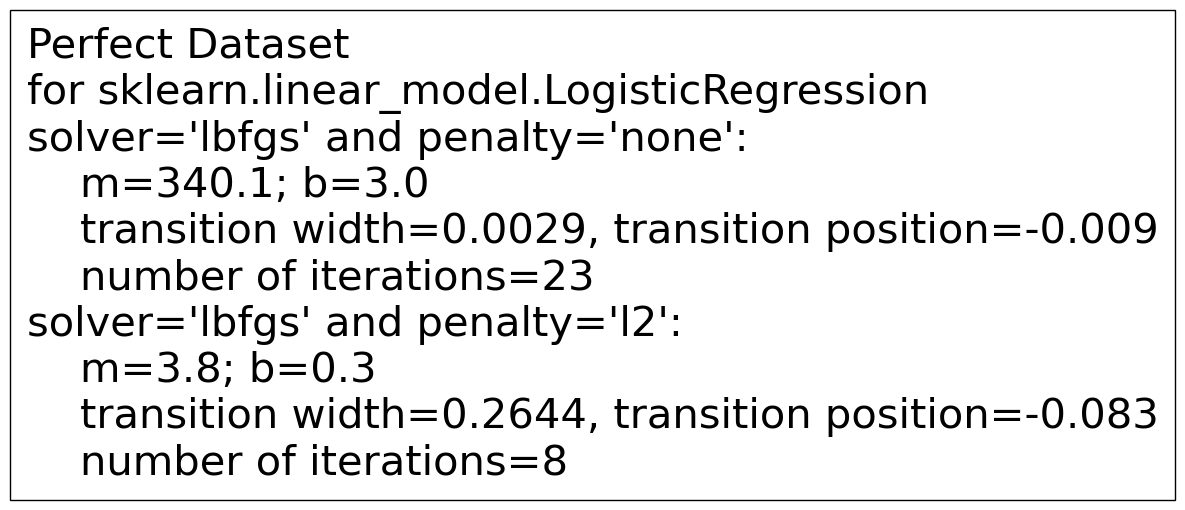

In [ ]:
perfectsklearn=sklearn.linear_model.LogisticRegression(random_state=0,penalty=None,solver="lbfgs").fit(x_perfect.reshape(-1,1),y_perfect)
(mp,bp)=(perfectsklearn.coef_.item(),perfectsklearn.intercept_.item())
imperfectsklearn=sklearn.linear_model.LogisticRegression(random_state=0,penalty="l2",solver="lbfgs").fit(x_perfect.reshape(-1,1),y_perfect)
(mip,bip)=(imperfectsklearn.coef_.item(),imperfectsklearn.intercept_.item())
text=[]
text.append("Perfect Dataset")
text.append("for sklearn.linear_model.LogisticRegression")
text.append("solver='lbfgs' and penalty='none':")
text.append("    m={0:.1f}; b={1:.1f}".format(mp,bp))
text.append("    transition width={0:.4f}, transition position={1:.3f}".format(1/mp,-bp/mp))
text.append("    number of iterations={0:n}".format(perfectsklearn.n_iter_.item()))
text.append("solver='lbfgs' and penalty='l2':")
text.append("    m={0:.1f}; b={1:.1f}".format(mip,bip))
text.append("    transition width={0:.4f}, transition position={1:.3f}".format(1/mip,-bip/mip))
text.append("    number of iterations={0:n}".format(imperfectsklearn.n_iter_.item()))
textbox(text,fname="perfectimperfect")

### Multiclass classification ###

In [ ]:
featuredata=[("SQUARE FEET",1000,"SQUARE FEET/1000"),("$/SQUARE FEET",100,"$/100 SQUARE FEET")]
classname="PROPERTY TYPE"
classdata=[("Condo/Co-op",0),("Townhouse",1),("Single Family Residential",2)]

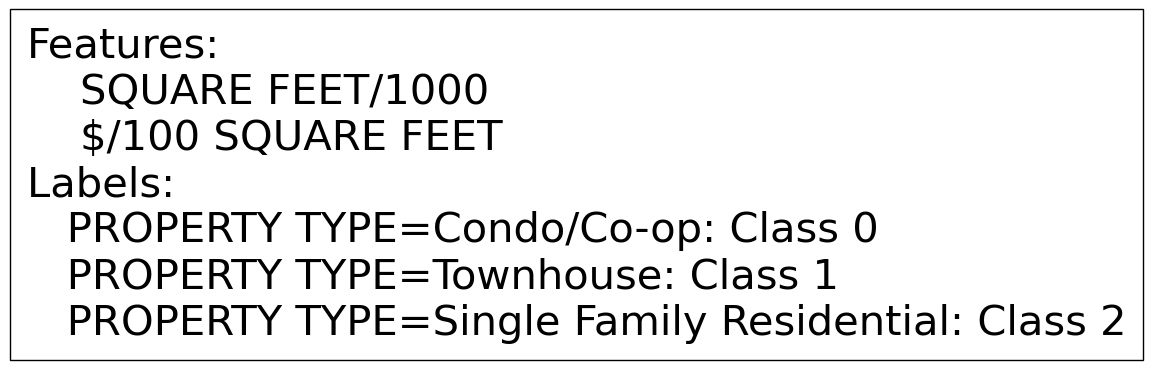

In [ ]:
text=[]
text.append("Features:")
for _,_,f in featuredata:
    text.append("    {0:s}".format(f))
text.append("Labels: ")
for c,n in classdata:
    text.append("   {0:s}={1:s}: Class {2:n}".format(classname,c,n))
textbox(text,fname="multiclass")

In [ ]:
(features,_,revisedfeaturenames)=list(zip(*featuredata))

In [ ]:
XY=pandas.DataFrame(0,index=data.index,columns=pandas.MultiIndex.from_product([["feature"],revisedfeaturenames]))
for (fname,scale,revisedfeaturename) in featuredata:
    XY[("feature",revisedfeaturename)]=data[fname]/scale

XY[("label","class")]=numpy.nan
for cname,cvalue in classdata:
    XY.loc[data[classname]==cname,("label","class")]=cvalue

beforedrop=XY.shape[0]
XY=XY.dropna(axis='index')
afterdrop=XY.shape[0]
print("{0:d} records dropped".format(beforedrop-afterdrop))
XY[("label","class")]=XY[("label","class")].astype(int)
XY.head()

26 records dropped


feature                   label
              SQUARE FEET/1000 $/100 SQUARE FEET class
record number                                         
1                        1.520              2.24     2
2                        0.900              2.21     0
3                        3.135              3.43     2
4                        3.219              2.56     1
5                        1.600              3.28     2

In [ ]:
XY.head(6).to_latex(buf="multiclassdata.tex",bold_rows=True,sparsify=False)

C:\Users\richa\AppData\Local\Temp\ipykernel_22928\1639397544.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  XY.head(6).to_latex(buf="multiclassdata.tex",bold_rows=True,sparsify=False)


In [ ]:
X=XY.loc[:,idx["feature",:]]
Y=XY[("label","class")]
X_1=X.iloc[:,0]
X_2=X.iloc[:,1]
_,X_1.name=X_1.name
_,X_2.name=X_2.name
flags=[(Y==c) for c in range(3)]

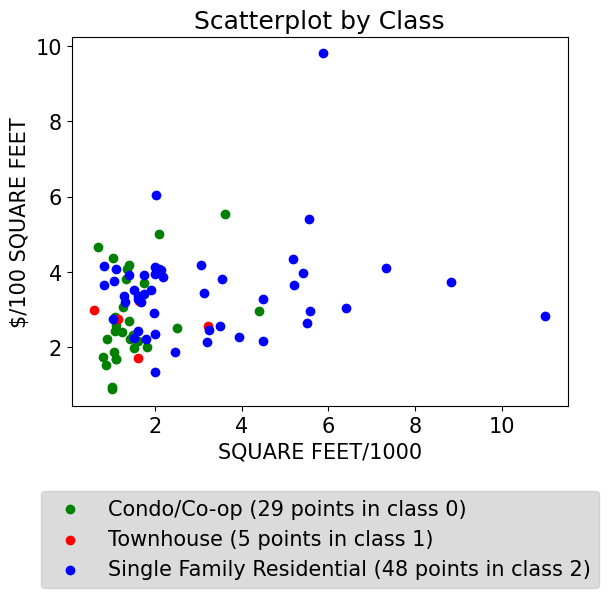

In [ ]:
plt.figure()
for (cname,cvalue),f,c in zip(classdata,flags,["green","red","blue"]):
    ff=flags[cvalue]
    plt.scatter(X_1[ff],X_2[ff],color=c,label="{0:s} ({1:d} points in class {2:n})".format(cname,ff.sum(),cvalue))
plt.xlabel(X_1.name)
plt.ylabel(X_2.name)
legend("bottom",ncol=1)
title=[]
(XA,XB)=plt.xlim()
(YA,YB)=plt.ylim()
title.append("Scatterplot by Class")
plt.title("\n".join(title))
saver("multiclass_scatterplot")
plt.show()
plt.close()

In [ ]:
(m0,b0)=((2,1),3)
(m1,b1)=((-1,0),0)
(m2,b2)=((1,-3),-1)

In [ ]:
def polytope(mb1,mbothers,radius=1):
    #returns vertex and other points to plot in a ball around vertex of radius
    (m1,b1)=mb1
    ((m2,b2),(m3,b3))=mbothers
    A=numpy.vstack([numpy.array(m1)-numpy.array(m2),numpy.array(m1)-numpy.array(m3)])
    b=numpy.vstack([b1-b2,b1-b3])
    signdet=numpy.sign(numpy.linalg.det(A))
    vertex=numpy.linalg.solve(A,-b).squeeze()
    p1=signdet*numpy.array([-A[0,1],A[0,0]])
    p2=signdet*numpy.array([A[1,1],-A[1,0]])
    dp=(p1-p2)/numpy.linalg.norm(p1-p2)
    nu=2*radius/numpy.linalg.norm(p2-p2.dot(dp)*dp)
    return vertex,[vertex+nu*p1,vertex+nu*p2]

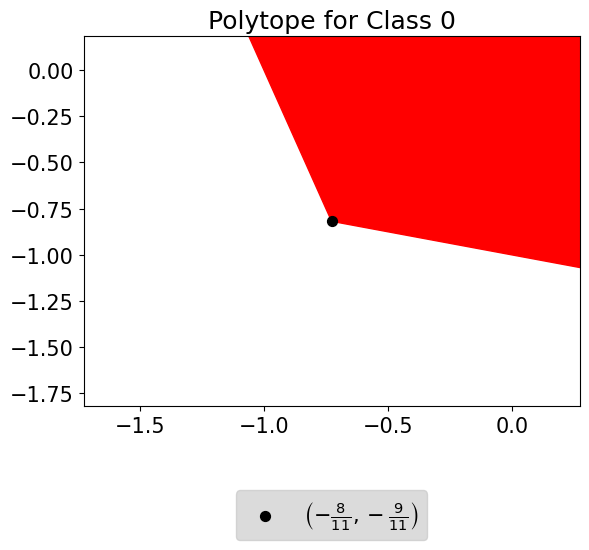

In [ ]:
#v,[p1,p2]=polytope((m1,b1),[(m2,b2),(m3,b3)])
v,[p1,p2]=polytope((m0,b0),[(m1,b1),(m2,b2)])
(xstar,ystar)=v
x,y=zip(*list([v,p1,p2]))

plt.figure()
plt.xlim(xstar-1,xstar+1)
plt.ylim(ystar-1,ystar+1)
plt.fill(x,y,color="red")
plt.scatter(-8/11,-9/11,s=50,color="black",label=r"$\left(-\frac{{8}}{{11}},-\frac{{9}}{{11}}\right)$")
legend("bottom")
title=[]
title.append("Polytope for Class 0")
plt.title("\n".join(title))
saver("polytope")
plt.show()
plt.close()

In [ ]:
clf = sklearn.linear_model.LogisticRegression(random_state=0,solver="newton-cg").fit(XY.loc[:,idx["feature",:]].values, XY[("label","class")].values)
print(clf.coef_)
print(clf.intercept_)

[[-0.39738122 -0.12626798]
 [-0.11127697 -0.23218217]
 [ 0.50865819  0.35845015]]
[ 1.57253565 -0.34680434 -1.22573131]


In [ ]:
df_multiclass=pandas.DataFrame(numpy.nan,columns=["m1","m2","b"],index=["Class 0","Class 1","Class 2"])
df_multiclass.loc[:,"b"]=clf.intercept_
df_multiclass.loc[:,["m1","m2"]]=clf.coef_
df_multiclass.to_latex(buf="multiclasscoeffs.tex",bold_rows=True,header=["$m_1$","$m_2$","b"],escape=False)
df_multiclass

C:\Users\richa\AppData\Local\Temp\ipykernel_22928\2793843282.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_multiclass.to_latex(buf="multiclasscoeffs.tex",bold_rows=True,header=["$m_1$","$m_2$","b"],escape=False)


,m1,m2,b
Class 0,-0.397381,-0.126268,1.572536
Class 1,-0.111277,-0.232182,-0.346804
Class 2,0.508658,0.358450,-1.225731


In [ ]:
(m0,b0)=(clf.coef_[0],clf.intercept_[0])
(m1,b1)=(clf.coef_[1],clf.intercept_[1])
(m2,b2)=(clf.coef_[2],clf.intercept_[2])

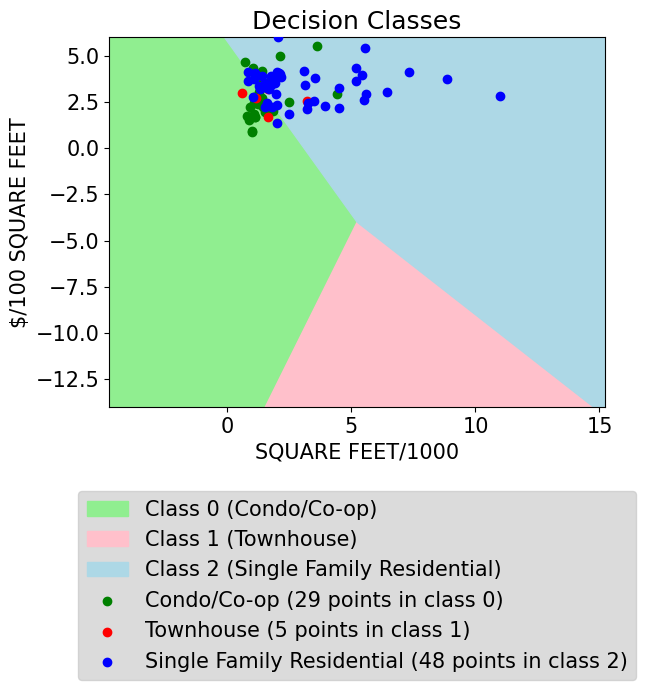

In [ ]:
plt.figure()


#first find radius to capture triple point and data
v,_=polytope((m0,b0),[(m1,b1),(m2,b2)])
(xstar,ystar)=v
(data_mean_x,data_mean_y)=(X_1.mean(),X_2.mean())
(data_std_x,data_std_y)=(X_1.std(),X_2.std())
radius=numpy.linalg.norm([data_mean_x-xstar,data_mean_y-ystar])+2*numpy.linalg.norm([data_std_x,data_std_y])


v,[p1,p2]=polytope((m0,b0),[(m1,b1),(m2,b2)],radius=radius)

x,y=zip(*list([v,p1,p2]))

plt.xlim(xstar-10,xstar+10)
plt.ylim(ystar-10,ystar+10)
plt.fill(x,y,color="lightgreen",label="Class 0 (Condo/Co-op)")

v,[p1,p2]=polytope((m1,b1),[(m2,b2),(m0,b0)],radius=radius*2)
(xstar,ystar)=v
x,y=zip(*list([v,p1,p2]))
plt.fill(x,y,color="pink",label="Class 1 (Townhouse)")

v,[p1,p2]=polytope((m2,b2),[(m0,b0),(m1,b1)],radius=radius*2)
(xstar,ystar)=v
x,y=zip(*list([v,p1,p2]))
plt.fill(x,y,color="lightblue",label="Class 2 (Single Family Residential)")


for (cname,cvalue),f,c in zip(classdata,flags,["green","red","blue"]):
    ff=flags[cvalue]
    plt.scatter(X_1[ff],X_2[ff],color=c,label="{0:s} ({1:d} points in class {2:n})".format(cname,ff.sum(),cvalue),zorder=5)
plt.xlabel(X_1.name)
plt.ylabel(X_2.name)
legend("bottom",ncol=1)


plt.xlabel(X_1.name)
plt.ylabel(X_2.name)
title=[]
title.append("Decision Classes")
plt.title("\n".join(title))
saver("datapolytope")
plt.show()
plt.close()